**Este notebook explora a predição da rugosidade em peças 3D usando regressão linear. Dois modelos foram avaliados: um com variáveis selecionadas com base na correlação e outro com todas as features de entrada**.

**O pipeline inclui padronização das variáveis, treino e teste do modelo, além da análise de resíduos e avaliação de desempenho. Também interpretamos os coeficientes para compreender o impacto de cada variável sobre a rugosidade das impressões.**

**O objetivo é fornecer uma visão clara de como os parâmetros de impressão influenciam a qualidade superficial e como a regressão linear pode ser aplicada nesse contexto.**

O conjunto de dados é oriundo de uma pesquisa do Departamento de Engenharia Mecânica da Universidade Selçuk (TR). O objetivo do estudo é determinar como os parâmetros de ajuste nas impressoras 3D afetam a qualidade, precisão e resistência da impressão. O estudo considera nove parâmetros de configuração e três parâmetros de saída medidos.

Parâmetros de Configuração:

Altura da Camada (mm)

Espessura da Parede (mm)

Densidade de Preenchimento (%)

Padrão de Preenchimento

Temperatura do Bico (ºC)

Temperatura da Mesa (ºC)

Velocidade de Impressão (mm/s)

Material

Velocidade do Ventilador (%)

Parâmetros de Saída: (Medidos)

Rugosidade (µm)
Resistência à Tensão (máxima) (MPa)
Alongamento (%)

Este trabalho é baseado nas configurações da impressora 3D Ultimaker S5 e nos filamentos utilizados. Os testes de material e resistência foram realizados em um tester da Sincotec GMBH, capaz de aplicar uma carga de até 20 kN.

Neste estudo, tentamos estimar qual a rugosidade utilizando regressão linear.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from IPython.display import Image, display

In [2]:
df = pd.read_csv('data.csv')
df.head(5)

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tension_strenght    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [4]:
df.isna().sum()

layer_height          0
wall_thickness        0
infill_density        0
infill_pattern        0
nozzle_temperature    0
bed_temperature       0
print_speed           0
material              0
fan_speed             0
roughness             0
tension_strenght      0
elongation            0
dtype: int64

In [5]:
np.unique(df['infill_pattern'])

array(['grid', 'honeycomb'], dtype=object)

A figura a seguir mostra o que significa ter diferentes tipos de **padrões de preenchimento** e diferentes tipos de **densidades de preenchimento**.

![Diferença dos materiais utilizados para a impressão.](img/infill_pattern.jpg)

In [6]:
np.unique(df['material'])

array(['abs', 'pla'], dtype=object)

Diferença dos **materiais** utilizados para a impressão.

![Diferença dos materiais utilizados para a impressão.](img/pla-abs.jpg)

In [7]:
df['infill_pattern'] = [1 if valor == 'grid' else 0 for valor in df['infill_pattern']]
df['material'] = [1 if valor == 'pla' else 0 for valor in df['material']]

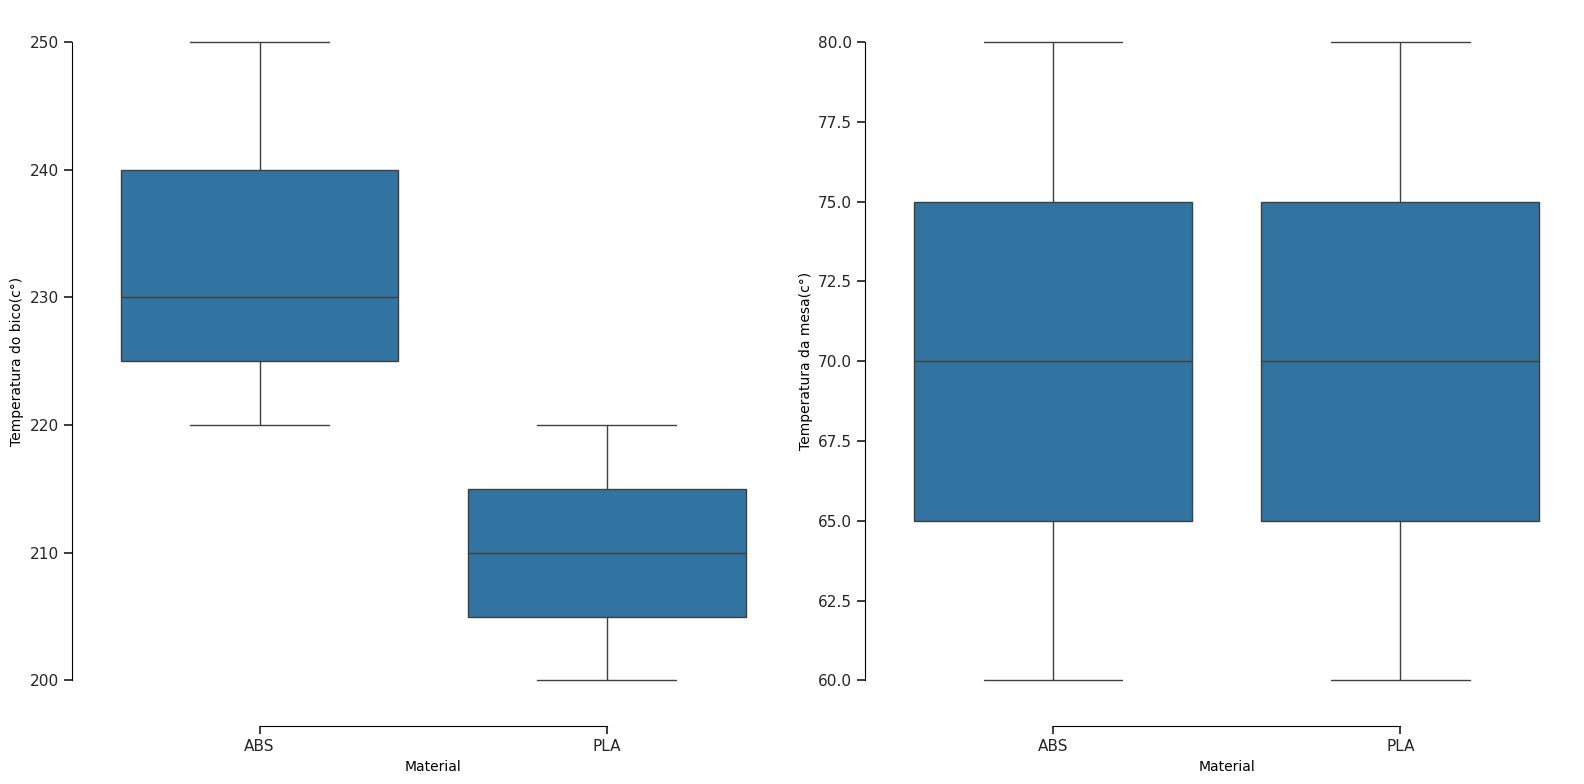

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="material", y="nozzle_temperature",
            data=df, ax=ax[0])

sns.boxplot(x='material', y='bed_temperature',
            data=df, ax=ax[1])

sns.despine(offset=10, trim=True)

ax[0].set_ylabel('Temperatura do bico(c°)')
ax[0].set_xlabel('Material')
ax[0].set_xticklabels(['ABS', 'PLA'])
ax[0].set_xticks([0, 1])

ax[1].set_ylabel('Temperatura da mesa(c°)')
ax[1].set_xlabel('Material')
ax[1].set_xticklabels(['ABS', 'PLA'])
ax[1].set_xticks([0, 1])


plt.tight_layout()
plt.show()

In [9]:
df.sample(5)

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
36,0.15,4,50,1,205,65,60,1,25,212,24,1.8
1,0.02,7,90,0,225,65,40,0,25,32,16,1.4
17,0.06,8,30,0,210,70,60,1,50,88,26,1.6
35,0.15,3,80,0,200,60,60,1,0,192,33,2.8
11,0.06,2,20,0,225,65,60,0,25,92,12,1.4


In [10]:
df.duplicated().sum() / len(df) * 100

np.float64(0.0)

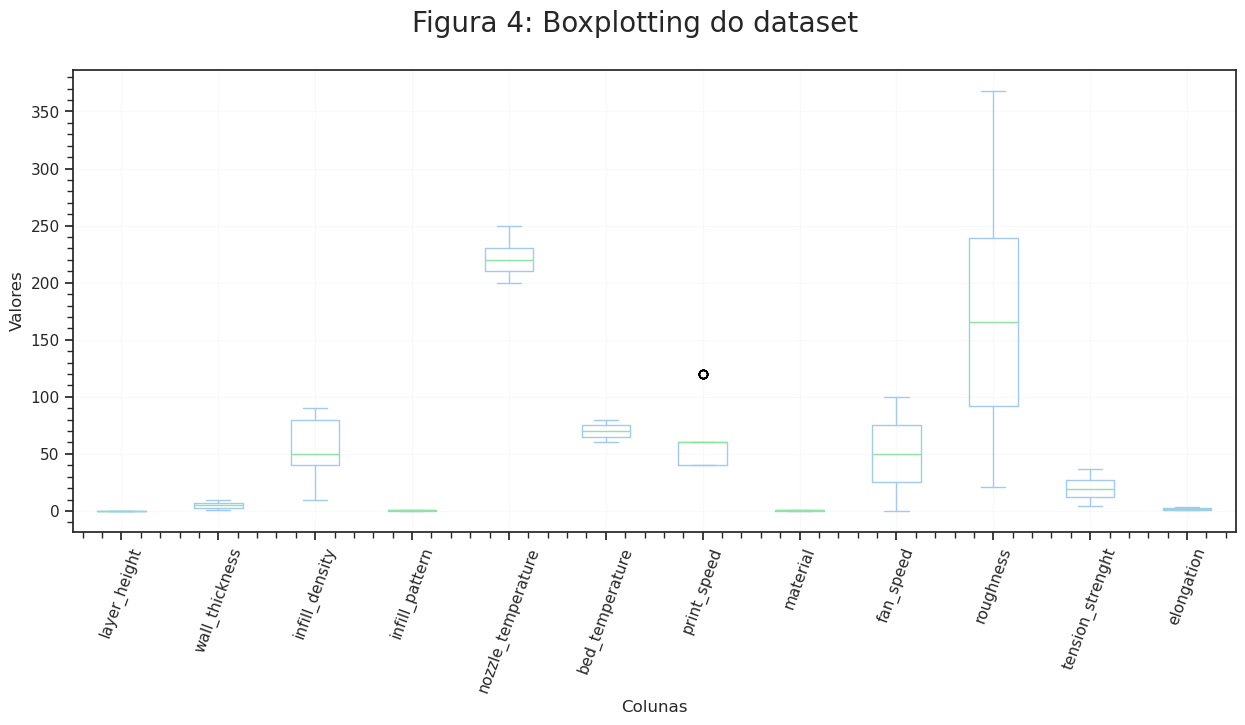

In [11]:
df.plot(kind='box',figsize=(15, 6));
plt.xlabel('Colunas')  
plt.ylabel('Valores') 
plt.grid(True, alpha=0.1)
plt.minorticks_on()
plt.suptitle('Figura 4: Boxplotting do dataset', size=20)
plt.tick_params(axis='x', rotation=70) 
plt.show()

Vamos verificar alguns Outliers contidos na coluna de velocidade de impressão

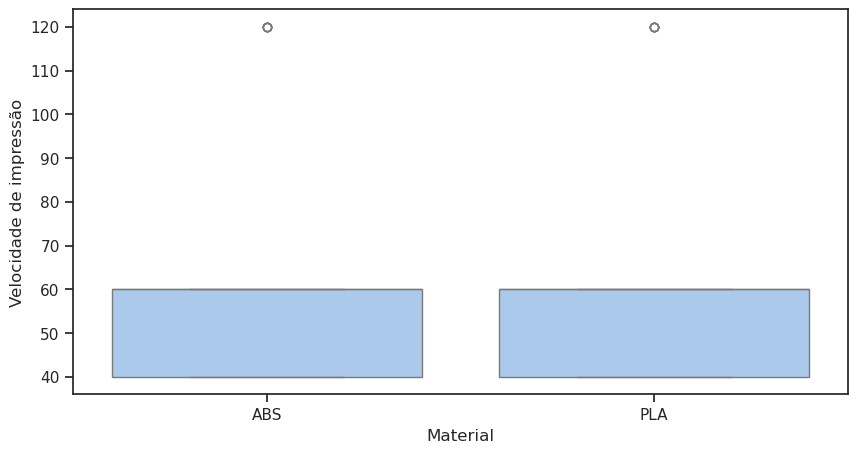

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(y='print_speed', x='material', data=df)
ax.set_ylabel('Velocidade de impressão')
ax.set_xlabel('Material')
ax.set_xticks([0, 1])
ax.set_xticklabels(['ABS', 'PLA'])

plt.show()

In [13]:
df[df['print_speed'] == 120]

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
20,0.1,1,40,1,220,60,120,0,0,120,16,1.2
21,0.1,2,30,0,225,65,120,0,25,144,12,1.1
22,0.1,1,50,1,230,70,120,0,50,265,10,0.9
23,0.1,9,80,0,240,75,120,0,75,312,19,0.8
24,0.1,2,60,1,250,80,120,0,100,368,8,0.4
25,0.1,1,50,0,200,60,120,1,0,180,11,1.6
26,0.1,4,40,1,205,65,120,1,25,176,12,1.2
27,0.1,3,50,0,210,70,120,1,50,128,18,1.8
28,0.1,4,90,1,215,75,120,1,75,138,34,2.9
29,0.1,1,30,0,220,80,120,1,100,121,14,1.5


Parece que há registros que contém velocidade de impressão setado em 120; Decidi não deletar.

## Preparação dos dados para modelagem
Nesta seção, faremos os seguintes passos:
 1. Verificação de correlação dos dados.
 2. Escalonamento dos atributos(Normalização/Padronização).
 3. Separação de dados de treino e teste.

## Seleção de features e análise de correlação
Nesta seção utilizaremos o heatmap do seaborn para verificarmos como as variáveis númericas se relacionam entre si.

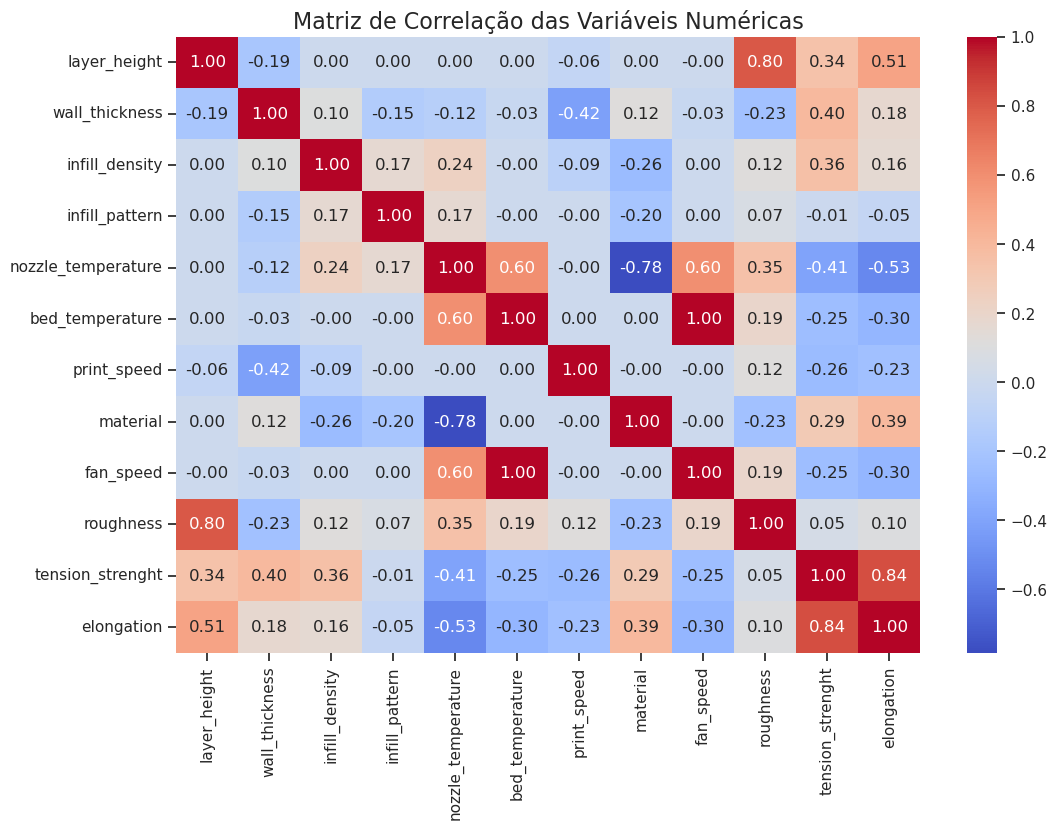

In [14]:
corr_pearson = df.corr()

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlação das Variáveis Numéricas", fontsize=16)
plt.show()

In [15]:
df.corr()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
layer_height,1.000000e+00,-0.192571,3.498560e-03,1.175539e-16,8.332953e-16,1.024570e-15,-5.550085e-02,8.707699e-17,-1.103383e-16,0.801341,0.338230,0.507583
wall_thickness,-1.925714e-01,1.000000,1.025762e-01,-1.451594e-01,-1.184929e-01,-2.932662e-02,-4.195307e-01,1.175100e-01,-2.932662e-02,-0.226987,0.399849,0.176364
infill_density,3.498560e-03,0.102576,1.000000e+00,1.672736e-01,2.386137e-01,-2.337202e-16,-9.430408e-02,-2.628585e-01,3.841975e-17,0.118389,0.358464,0.159009
infill_pattern,1.175539e-16,-0.145159,1.672736e-01,1.000000e+00,1.703995e-01,-4.019437e-17,-4.592899e-17,-2.000000e-01,2.411662e-17,0.068340,-0.009054,-0.046138
nozzle_temperature,8.332953e-16,-0.118493,2.386137e-01,1.703995e-01,1.000000e+00,6.024534e-01,-5.901839e-16,-7.838379e-01,6.024534e-01,0.348611,-0.405908,-0.527447
bed_temperature,1.024570e-15,-0.029327,-2.337202e-16,-4.019437e-17,6.024534e-01,1.000000e+00,9.681476e-16,1.406803e-16,1.000000e+00,0.192142,-0.252883,-0.300871
print_speed,-5.550085e-02,-0.419531,-9.430408e-02,-4.592899e-17,-5.901839e-16,9.681476e-16,1.000000e+00,-3.867705e-17,-1.312743e-17,0.121066,-0.264590,-0.234052
material,8.707699e-17,0.117510,-2.628585e-01,-2.000000e-01,-7.838379e-01,1.406803e-16,-3.867705e-17,1.000000e+00,-4.019437e-18,-0.233173,0.289726,0.394737
fan_speed,-1.103383e-16,-0.029327,3.841975e-17,2.411662e-17,6.024534e-01,1.000000e+00,-1.312743e-17,-4.019437e-18,1.000000e+00,0.192142,-0.252883,-0.300871
roughness,8.013409e-01,-0.226987,1.183890e-01,6.834030e-02,3.486108e-01,1.921416e-01,1.210657e-01,-2.331730e-01,1.921416e-01,1.000000,0.051617,0.098962


In [16]:
df['roughness'].describe()

count     50.000000
mean     170.580000
std       99.034129
min       21.000000
25%       92.000000
50%      165.500000
75%      239.250000
max      368.000000
Name: roughness, dtype: float64

Atributos bastante desbalanceados, usaremos a função StandardScaler do scikitlearn para deixarmos os dados na mesma variância.

In [17]:
# Features e target (Modelo 1)
features_1 = ['layer_height', 'material', 'nozzle_temperature']
X = df[features_1]
y = df['roughness']

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Criar pipeline: padronização + regressão linear
pipeline = Pipeline([
    ("scaler", StandardScaler()),      # padroniza as features
    ("regressor", LinearRegression())  # modelo de regressão linear
])

## Preparação dos dados e treino do modelo

Nesta etapa, realizamos os seguintes procedimentos:

Seleção de features e target:

Escolhemos as variáveis layer_height, material e nozzle_temperature como features (X) e roughness como variável alvo (y).

Separação dos dados em treino e teste:

Os dados foram divididos em 80% para treino e 20% para teste, garantindo que o modelo seja avaliado em dados não vistos durante o treinamento.

Padronização das features:

Utilizamos o StandardScaler para padronizar as features, transformando cada uma em uma distribuição com média 0 e desvio padrão 1. Isso é importante para que todas as variáveis tenham a mesma escala e o modelo linear não seja enviesado por magnitudes diferentes.

Treinamento do modelo:

Criamos uma Pipeline combinando a padronização e a Regressão Linear.

O modelo foi treinado com os dados de treino e posteriormente testado nos dados de teste.

Avaliação:

O desempenho foi avaliado usando Mean Squared Error (MSE) e R², e os resultados foram visualizados em um gráfico comparando valores reais e preditos da rugosidade.

MSE: 2976.8855995245576 | R²: 0.3584146176903854


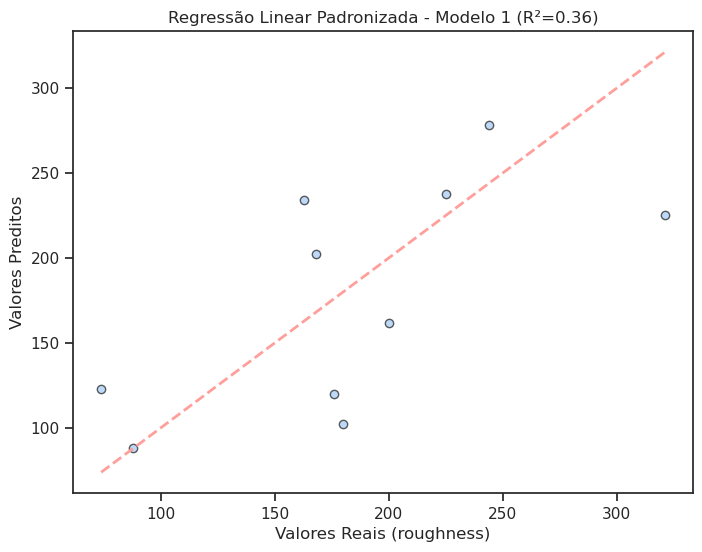

In [18]:
# Treinar modelo
pipeline.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = pipeline.predict(X_test)

# Avaliar modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse, "| R²:", r2)

# Plotar resultados
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reais (roughness)")
plt.ylabel("Valores Preditos")
plt.title(f"Regressão Linear Padronizada - Modelo 1 (R²={r2:.2f})")
plt.show()

O Modelo 1 usando layer_height, material e nozzle_temperature como features conseguiu:

MSE: ~2976.89 → mostra o erro médio quadrático das previsões.

R²: 0.36 → indica que o modelo explica aproximadamente 36% da variação da rugosidade.

Observações:

O R² não é muito alto, o que sugere que essas três features não capturam toda a variação da rugosidade.

Vamos verificar o impacto das features do primeiro modelo na Rugosidade

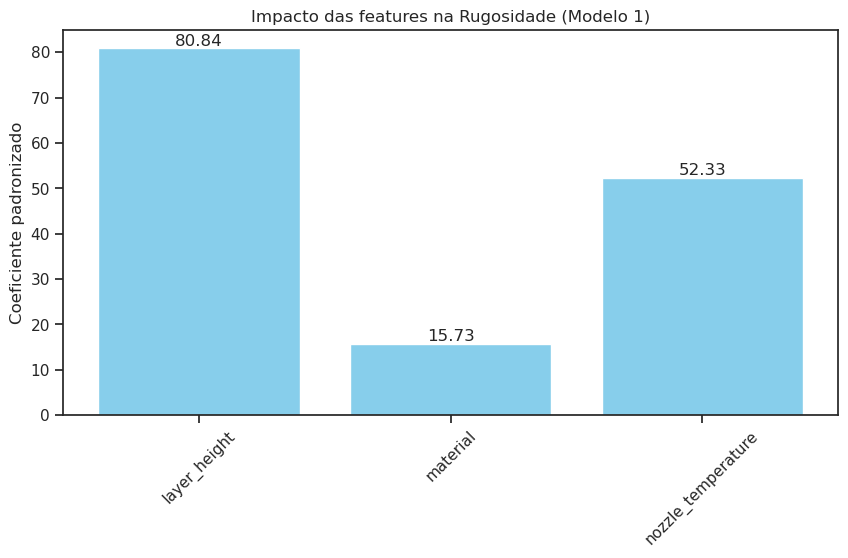

In [19]:
# Coeficientes padronizados do Modelo 2
coeficientes = pipeline.named_steps['regressor'].coef_
features1 = features_1

# Plot
plt.figure(figsize=(10,5))
bars = plt.bar(features1, coeficientes, color='skyblue')
plt.axhline(0, color='black', linewidth=0.8)

# Adicionar valores em cima das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02*np.sign(yval), f'{yval:.2f}', 
             ha='center', va='bottom' if yval>0 else 'top')

plt.ylabel("Coeficiente padronizado")
plt.xticks(rotation=45)
plt.title("Impacto das features na Rugosidade (Modelo 1)")
plt.show()


Agora faremos um outro modelo que recebe todas as features de entrada, e analisaremos como ele se sai.

MSE: 978.3582887008877 | R²: 0.7891419217479536


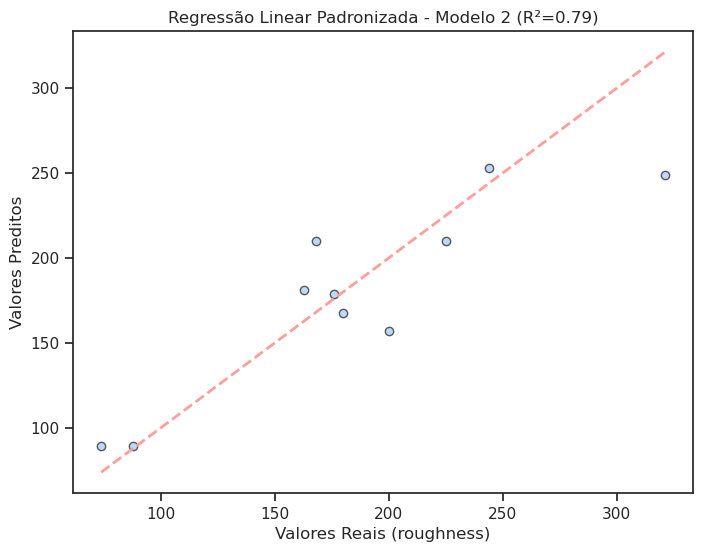

In [20]:
# Selecionar features (todas exceto as variáveis de saída)
features_2 = ['layer_height', 'wall_thickness', 'infill_density', 'infill_pattern', 
              'nozzle_temperature', 'bed_temperature', 'print_speed', 'material', 'fan_speed']

X = df[features_2]
y = df['roughness']

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Criar pipeline: padronização + regressão linear
pipeline2 = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

# Treinar modelo
pipeline2.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = pipeline2.predict(X_test)

# Avaliar modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse, "| R²:", r2)

# Plotar resultados
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reais (roughness)")
plt.ylabel("Valores Preditos")
plt.title(f"Regressão Linear Padronizada - Modelo 2 (R²={r2:.2f})")
plt.show()

O Modelo 2, usando todas as features de entrada (exceto as variáveis de saída), apresentou um desempenho bem melhor que o Modelo 1:

MSE: 978.36

R²: 0.79

Isso indica que incluir mais variáveis de entrada ajuda bastante a explicar a rugosidade (roughness).

Além disso, o gráfico de dispersão mostra que os valores preditos estão bem próximos dos valores reais, evidenciando que o modelo captura bem o padrão do dataset.

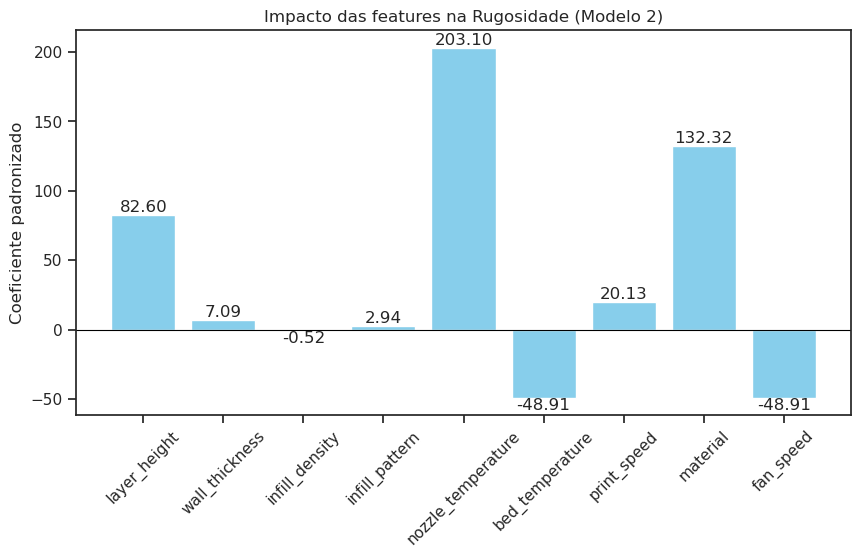

In [21]:
# Coeficientes padronizados do Modelo 2
coeficientes2 = pipeline2.named_steps['regressor'].coef_
features2 = features_2

# Plot
plt.figure(figsize=(10,5))
bars = plt.bar(features2, coeficientes2, color='skyblue')
plt.axhline(0, color='black', linewidth=0.8)

# Adicionar valores em cima das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02*np.sign(yval), f'{yval:.2f}', 
             ha='center', va='bottom' if yval>0 else 'top')

plt.ylabel("Coeficiente padronizado")
plt.xticks(rotation=45)
plt.title("Impacto das features na Rugosidade (Modelo 2)")
plt.show()


Impacto das Features no Modelo 2:

O Modelo 2 utilizou todas as variáveis de entrada do dataset (exceto as variáveis de saída) para prever a rugosidade (roughness).

O gráfico de coeficientes padronizados mostra a influência relativa de cada feature:

Valores positivos indicam que o aumento da feature tende a aumentar a rugosidade.

Valores negativos indicam que o aumento da feature tende a diminuir a rugosidade.

A magnitude do coeficiente indica a importância relativa da feature no modelo.

Dessa forma, podemos identificar rapidamente quais parâmetros de impressão têm maior impacto na rugosidade final do material, permitindo ajustes mais precisos no processo de impressão 3D.

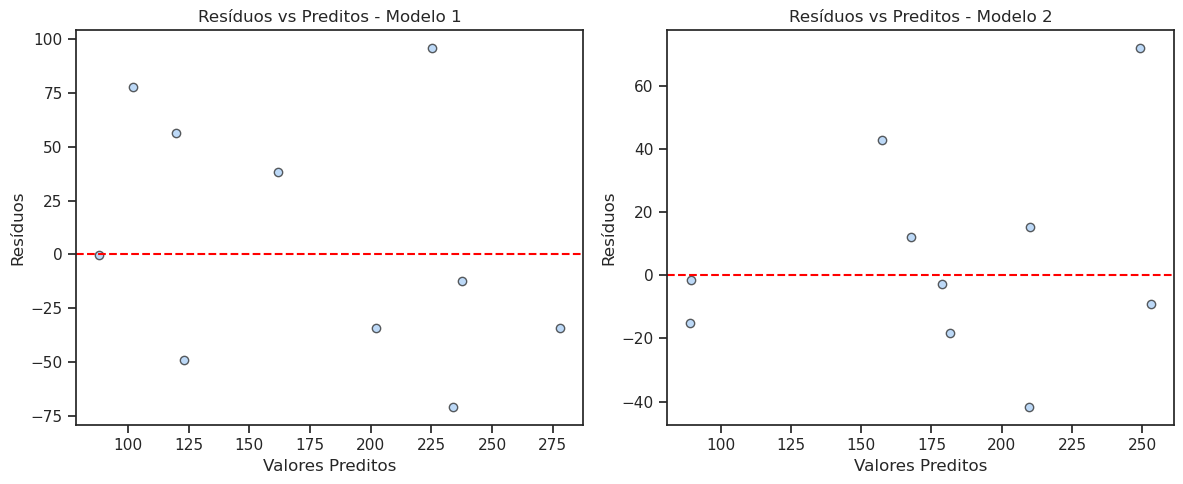

In [24]:
# Selecionar apenas as features do modelo 1
X_test_modelo_1 = X_test[features_1]

# Calcular resíduos
residuos_modelo_1 = y_test - pipeline.predict(X_test_modelo_1)

# Para o Modelo 2, podemos usar X_test completo
residuos_modelo_2 = y_test - pipeline2.predict(X_test)

# Plotar resíduos
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(pipeline.predict(X_test_modelo_1), residuos_modelo_1, alpha=0.7, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Preditos - Modelo 1')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')

plt.subplot(1,2,2)
plt.scatter(pipeline2.predict(X_test), residuos_modelo_2, alpha=0.7, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Preditos - Modelo 2')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')

plt.tight_layout()
plt.show()


## Conclusão Final

Neste estudo, investigamos a predição da rugosidade (roughness) de peças impressas em 3D a partir de diferentes parâmetros de impressão. Foram construídos dois modelos de regressão linear com diferentes conjuntos de features:

Modelo 1: utilizou apenas três variáveis — layer_height, material e nozzle_temperature. Este modelo apresentou um desempenho moderado, com R² = 0.36, indicando que essas três features explicam apenas parcialmente a variação na rugosidade das peças.

Modelo 2: considerou todas as variáveis de entrada disponíveis, exceto as variáveis de saída (roughness, tension_strenght e elongation). Este modelo teve desempenho significativamente melhor, com R² = 0.79, mostrando que múltiplos fatores de impressão contribuem para determinar a rugosidade final.

A análise dos resíduos para ambos os modelos mostrou que, embora o Modelo 2 tenha reduzido o erro e melhorado a acurácia, ainda há alguma variação não explicada, sugerindo que fatores adicionais ou interações entre features poderiam ser explorados em estudos futuros.

Insights principais:

Variáveis como bed_temperature, print_speed e fan_speed têm impacto relevante na rugosidade.

Modelos com poucas features podem ser úteis para interpretações rápidas, mas podem não capturar toda a complexidade do processo.

A padronização das variáveis antes do treinamento é essencial para a performance da regressão linear.

Próximos passos recomendados:

Explorar modelos não lineares (como Random Forest ou Gradient Boosting) para capturar possíveis interações complexas entre as variáveis.

Analisar a importância das features e possíveis correlações entre elas.

Validar o modelo em novos conjuntos de dados para avaliar sua robustez e generalização.